# Z3 Solver Project Demo
Presentation purposes

*Svolto per la presentazione del progetto all'orale*

In [1]:
import pandas as pd 
import numpy as np 
import itertools 
from model import TimetableScheduler
from z3 import *

## Scenario 1: Toy Model
Simple model containing just a few sessions and courses, not intended to be realistic in any way

*Modello semplice che contiene qualche sessione e corsi, inteso solo per motivi di testing*

Corsi:
- Maths 101
    - Sessioni: 2, 2
    - Tenuto dal prof. John Smith
    - Frequentato dalle classi 1, 3
- Intro. to Wizardry
    - Sessioni: 3, 1
    - Tenuto dal prof. John Smith
    - Frequentata dalla classe 2
- Reading 102
    - Sessioni: 1, 2
    - Tenuto dal prof. Andrea Garfields
    - Frequentata dalla classe 1
- Musical Analysis
    - Sessioni: 2, 5
    - Tenuto dal prof. John Doe
    - Frequentata dalle classi 2, 3
- Advanced English
    - Sessioni: 2
    - Tenuto dal prof. Andrea Garfields
    - Frequentata dalla classe 1
- Tennis
    - Sessioni: 1
    - Tenuto dal prof. Jane Doe
    - Frequentata dalla classe 2

Aule:
- Una aula grande (200 persone)
- Una aula media (100 persone)
- Una aula piccola (50 persone)
- Una aula piccolissima (10 persone)

In [2]:
import pandas as pd 
import numpy as np 
import itertools 
from model import TimetableScheduler
from z3 import *

In [2]:
toy_schedule = TimetableScheduler('sample_1', 5, 3)
toy_schedule.start()

In [3]:
toy_schedule.add_constraints()

In [4]:
toy_schedule.solve()

TIME TABLE SUCCESSFULLY CREATED
Saving the schedule in the SQL Database...
Schedule saved


In [5]:
from IPython.display import display, HTML
df = toy_schedule.print_schedule_df()
display(HTML(df.to_html().replace("\\n", "<br>")))

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
03:00 - 04:00,> Musical Analysis [Medium Room],> Introduction to Wizardry [Small Room],> Maths 101 [Big Room]> Tennis 101 [Small Room],> NO LECTURES / ACTIVITIES,> NO LECTURES / ACTIVITIES,> NO LECTURES / ACTIVITIES
04:00 - 05:00,> Musical Analysis [Medium Room],> Introduction to Wizardry [Small Room],> Maths 101 [Big Room],> Reading 102 [Medium Room],> NO LECTURES / ACTIVITIES,> Reading 102 [Big Room]
05:00 - 06:00,> Musical Analysis [Medium Room],> Introduction to Wizardry [Small Room],> Maths 101 [Big Room],> Reading 102 [Medium Room],> NO LECTURES / ACTIVITIES,> NO LECTURES / ACTIVITIES
06:00 - 07:00,> Musical Analysis [Medium Room],> Musical Analysis [Medium Room],> Maths 101 [Big Room],> Advanced English [Small Room],> NO LECTURES / ACTIVITIES,> NO LECTURES / ACTIVITIES
07:00 - 08:00,> Musical Analysis [Medium Room],> Musical Analysis [Medium Room],> NO LECTURES / ACTIVITIES,> Advanced English [Small Room],> NO LECTURES / ACTIVITIES,> NO LECTURES / ACTIVITIES


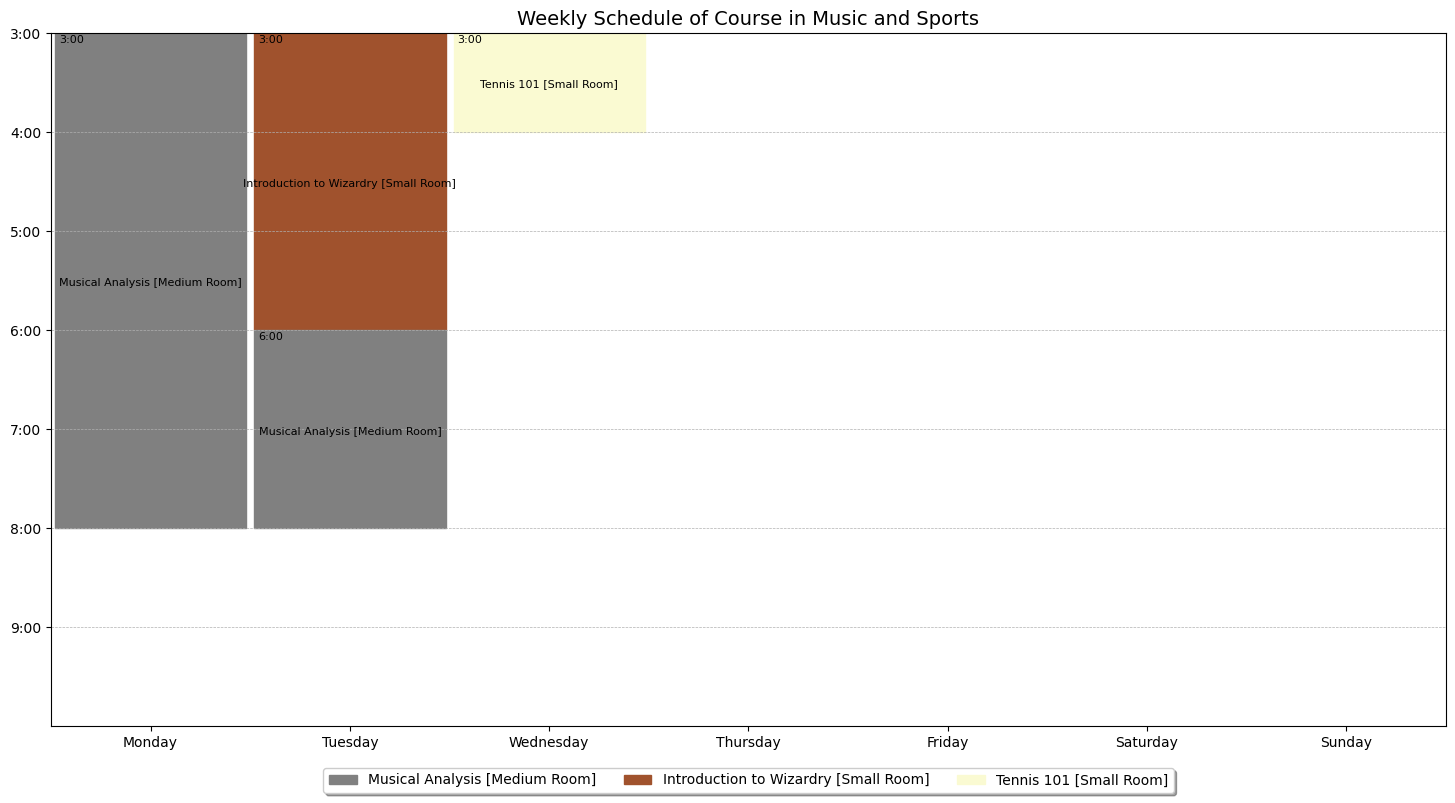

In [7]:
toy_schedule.draw_calendar('wow', 'cds', 2)

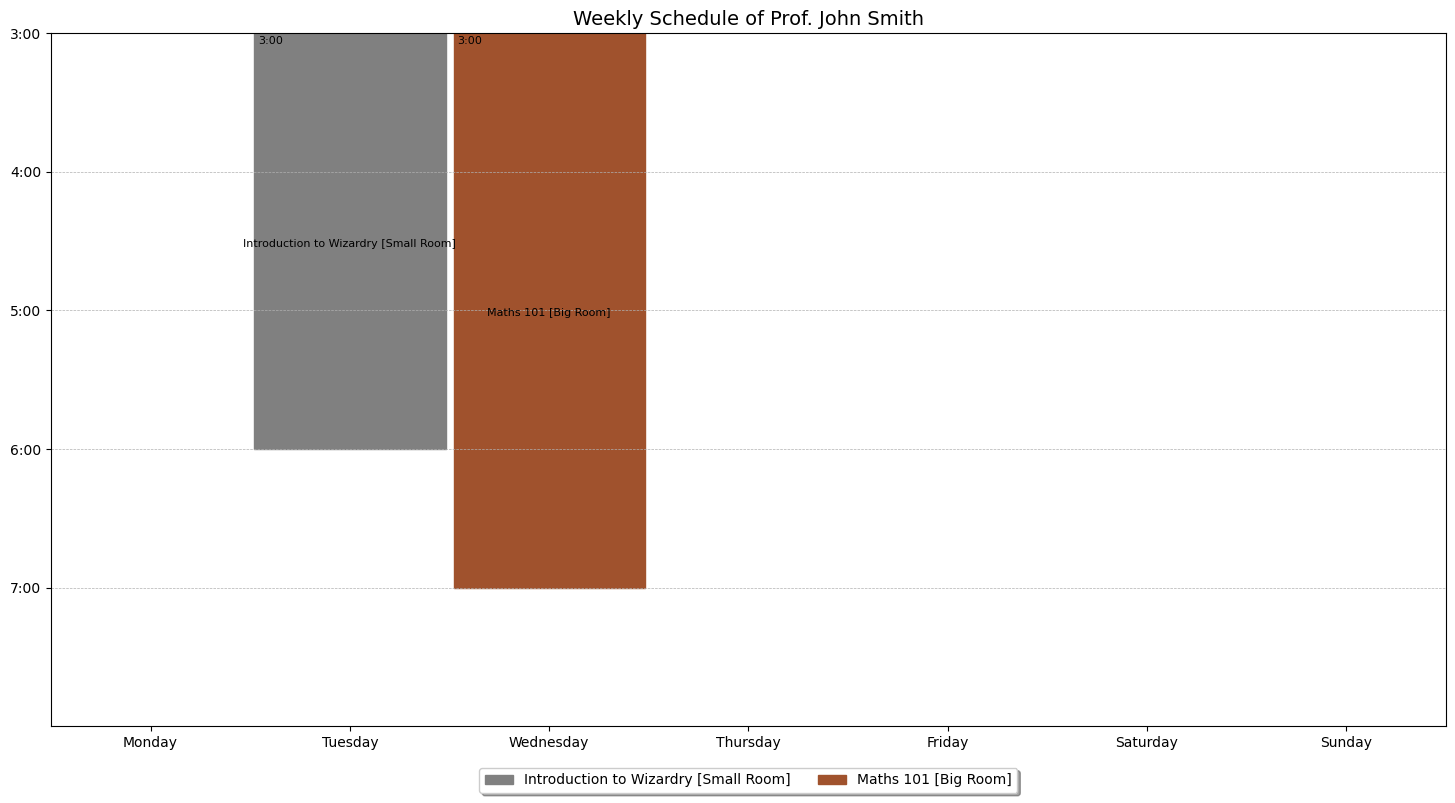

In [8]:
toy_schedule.draw_calendar('wow', 'prof', 1)

In [9]:
toy_schedule.end()

## Scenario 2: Next Semester's Courses for AIDA
Simplified model containing (estimated) sessions and courses for the next semester in AIDA.

*Modello semplificato che contiene i corsi del prossimo semestre del CdS triennale in IADA (2025-2026, Primo Semestre)*

Vincoli aggiuntivi: 
- Non ci sono lezioni il sabato
$$
\forall S, T, A, \text{ s.t. }T\text{ rappresenta un'ora in sabato }(\lfloor T/6 \rfloor = 6), X_{S,T,A} \implies \text{False}
$$

- Gli studenti del 1°, 2° e del 3° anno hanno orari di pranzo diversi per evitare il sovraffollamento delle mense (2°, 3° sono raggruppati assieme per semplicità). Ovvero, a loro si garantiscono delle "ore vuote" per pranzare che sono diverse a seconda dell'anno.
    - Si suppone che tramite un sondaggio si è deciso che quelli del 1° anno pranzano alle 12-13 e quelli del 2°, 3° anno alle 13-14

$$
\bigvee_{\begin{gather*}S,T,A\\ \tiny{T \text{ rappresenta una fascia oraria dalle 12-13}}, \\ \tiny{S\text{ è una sessione di un corso del 1° anno}}\end{gather*}} \neg X_{S,T,A}
$$

e

$$
\bigvee_{\begin{gather*}S,T,A\\ \tiny{T \text{ rappresenta una fascia oraria dalle 13-14}}, \\ \tiny{S\text{ è una sessione di un corso del 2° e del 3° anno}}\end{gather*}} \neg X_{S,T,A}
$$

In [3]:
orario_aida = TimetableScheduler('aida', 9, 8)

In [4]:
orario_aida.start()

In [12]:
from z3 import Not

In [13]:
# add custom constraint: no lezioni il sabato
for (S,T,A) in itertools.product(orario_aida.indexes['Sessions'],
                                 orario_aida.T,
                                 orario_aida.indexes['Rooms']):
    if (T // 9) == (6-1):
        orario_aida.solver.add(Not(orario_aida.X[S,T,A]))


In [14]:
# add custom constraint: turnazione delle mense
# osserviamo che i numeri 3, 4 rappresentano le fasce orarie 12-13 e 13-14 del lunedì. Se le sommiamo ad un multiplo di 9 otteniamo la stessa fascia oraria, riferita ad un altro giorno.
courses_1 = orario_aida.database.get_courses(1)
courses_2 = orario_aida.database.get_courses(2)
courses_3 = orario_aida.database.get_courses(3)

i = 3
while i < max(orario_aida.T):
    for course in courses_1:
        orario_aida.solver.add(And([
            Not(orario_aida.X[S,i, A]) for (S,A) in itertools.product(orario_aida.database.get_sessions(course), orario_aida.indexes['Rooms'])
        ]))

    i += 9

i = 4
while i < max(orario_aida.T):
    for course in courses_2:
        orario_aida.solver.add(And([
            Not(orario_aida.X[S,i, A]) for (S,A) in itertools.product(orario_aida.database.get_sessions(course), orario_aida.indexes['Rooms'])
        ]))

    for course in courses_3:
        orario_aida.solver.add(And([
            Not(orario_aida.X[S,i, A]) for (S,A) in itertools.product(orario_aida.database.get_sessions(course), orario_aida.indexes['Rooms'])
        ]))

    i += 9

In [15]:
orario_aida.add_constraints()

In [16]:

orario_aida.solve()

TIME TABLE SUCCESSFULLY CREATED
Saving the schedule in the SQL Database...
Schedule saved


In [17]:
from IPython.display import display, HTML 
df = orario_aida.print_schedule_df()
display(HTML(df.to_html().replace("\\n", "<br>")))

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
08:00 - 09:00,"> ALGEBRA LINEARE ED ELEMENTI DI GEOMETRIA [H3, 1A]> INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 2A]","> ALGEBRA LINEARE ED ELEMENTI DI GEOMETRIA [H2 Bis, 2A MORIN]> COMPUTABILITà, COMPLESSITà E LOGICA [H3, 2C]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 1A]> INFERENZA STATISTICA [H2 Bis, 3B]","> PROGRAMMAZIONE AVANZATA E PARALLELA [H3, 1B]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 2B]> ALGORITMI E STRUTTURE DATI [H3, 2A]",> NO LECTURES / ACTIVITIES
09:00 - 10:00,"> ALGEBRA LINEARE ED ELEMENTI DI GEOMETRIA [H3, 1A]> INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 2A]","> ALGEBRA LINEARE ED ELEMENTI DI GEOMETRIA [H2 Bis, 2A MORIN]> COMPUTABILITà, COMPLESSITà E LOGICA [H3, 2C]> SISTEMI COMPLESSI [H3, 1A]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 1A]> INFERENZA STATISTICA [H2 Bis, 3B]","> ANALISI 1 [H3, 2A]> PROGRAMMAZIONE AVANZATA E PARALLELA [H3, 1B]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 2B]> ALGORITMI E STRUTTURE DATI [H3, 2A]",> NO LECTURES / ACTIVITIES
10:00 - 11:00,"> COMPUTABILITà, COMPLESSITà E LOGICA [H2 Bis, 2A MORIN]> INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 2A]","> COMPUTABILITà, COMPLESSITà E LOGICA [H2 Bis, 2A MORIN]> SISTEMI COMPLESSI [H3, 1A]","> PROGRAMMAZIONE AVANZATA E PARALLELA [H3, 1C]","> ANALISI 1 [H3, 2A]> INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 1B]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 2B]> INFERENZA STATISTICA [H2 Bis, 2A MORIN]",> NO LECTURES / ACTIVITIES
11:00 - 12:00,"> COMPUTABILITà, COMPLESSITà E LOGICA [H2 Bis, 2A MORIN]","> COMPUTABILITà, COMPLESSITà E LOGICA [H2 Bis, 2A MORIN]","> PROGRAMMAZIONE AVANZATA E PARALLELA [H3, 1C]","> INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 1B]","> INFERENZA STATISTICA [H2 Bis, 2A MORIN]",> NO LECTURES / ACTIVITIES
12:00 - 13:00,"> ANALISI 1 [H3, 2B]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 1B]","> ALGEBRA LINEARE ED ELEMENTI DI GEOMETRIA [H3, 2B]",> NO LECTURES / ACTIVITIES,> NO LECTURES / ACTIVITIES,> NO LECTURES / ACTIVITIES
13:00 - 14:00,"> ANALISI 1 [H3, 2B]> INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 2C]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 1B]> ALGORITMI E STRUTTURE DATI [H3, 2C]> INTRODUZIONE AL MACHINE LEARNING [H2 Bis, 5A]","> ALGEBRA LINEARE ED ELEMENTI DI GEOMETRIA [H3, 2B]> SISTEMI COMPLESSI [H2 Bis, 4C]","> PROGRAMMAZIONE AVANZATA E PARALLELA [H3, 1A]","> INFERENZA STATISTICA [H3, 1B]",> NO LECTURES / ACTIVITIES
14:00 - 15:00,"> ARCHITETTURE DEGLI ELABORATORI [H3, 1A]> INTRODUZIONE ALL INTELLIGENZA ARTIFICIALE [H3, 2C]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 1B]> ALGORITMI E STRUTTURE DATI [H3, 2C]> INTRODUZIONE AL MACHINE LEARNING [H2 Bis, 5A]","> SISTEMI COMPLESSI [H2 Bis, 4C]","> PROGRAMMAZIONE AVANZATA E PARALLELA [H3, 1A]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 2B]> INFERENZA STATISTICA [H3, 1B]",> NO LECTURES / ACTIVITIES
15:00 - 16:00,"> ARCHITETTURE DEGLI ELABORATORI [H3, 1A]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 1B]> ALGORITMI E STRUTTURE DATI [H3, 1C]","> ANALISI 1 [H2 Bis, 2A MORIN]> SISTEMI COMPLESSI [H2 Bis, 4C]","> INTRODUZIONE AL MACHINE LEARNING [H2 Bis, 3B]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 2B]> INTRODUZIONE AL MACHINE LEARNING [H3, 2C]",> NO LECTURES / ACTIVITIES
16:00 - 17:00,"> ARCHITETTURE DEGLI ELABORATORI [H3, 1A]","> ALGORITMI E STRUTTURE DATI [H3, 1C]","> ANALISI 1 [H2 Bis, 2A MORIN]","> INTRODUZIONE AL MACHINE LEARNING [H2 Bis, 3B]","> INTRODUZIONE ALLA PROGRAMMAZIONE E LABORATORIO [H3, 2B]> INTRODUZIONE AL MACHINE LEARNING [H3, 2C]",> NO LECTURES / ACTIVITIES


c:\Users\ACER\Desktop\CourseTimetablingCSP\weekplot.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),


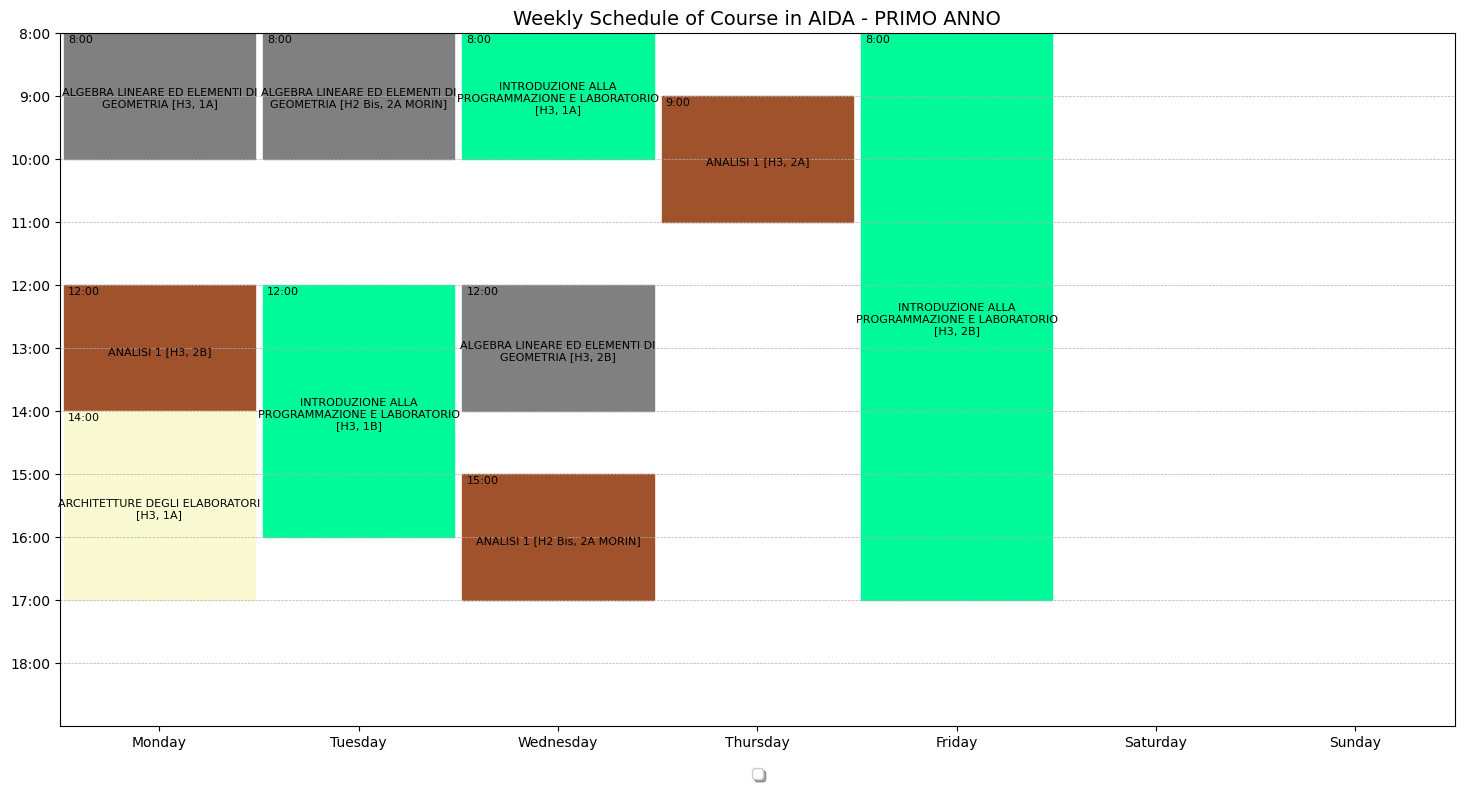

In [5]:
orario_aida.draw_calendar('AIDA', 'cds', 1)
# POTENTIAL PROBLEM DETECTED: With the current method, if there are two sessions with the same room and 
# the same course then they will be mistaken for the same course. / ! \ TO FIX TODO

c:\Users\ACER\Desktop\CourseTimetablingCSP\weekplot.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),


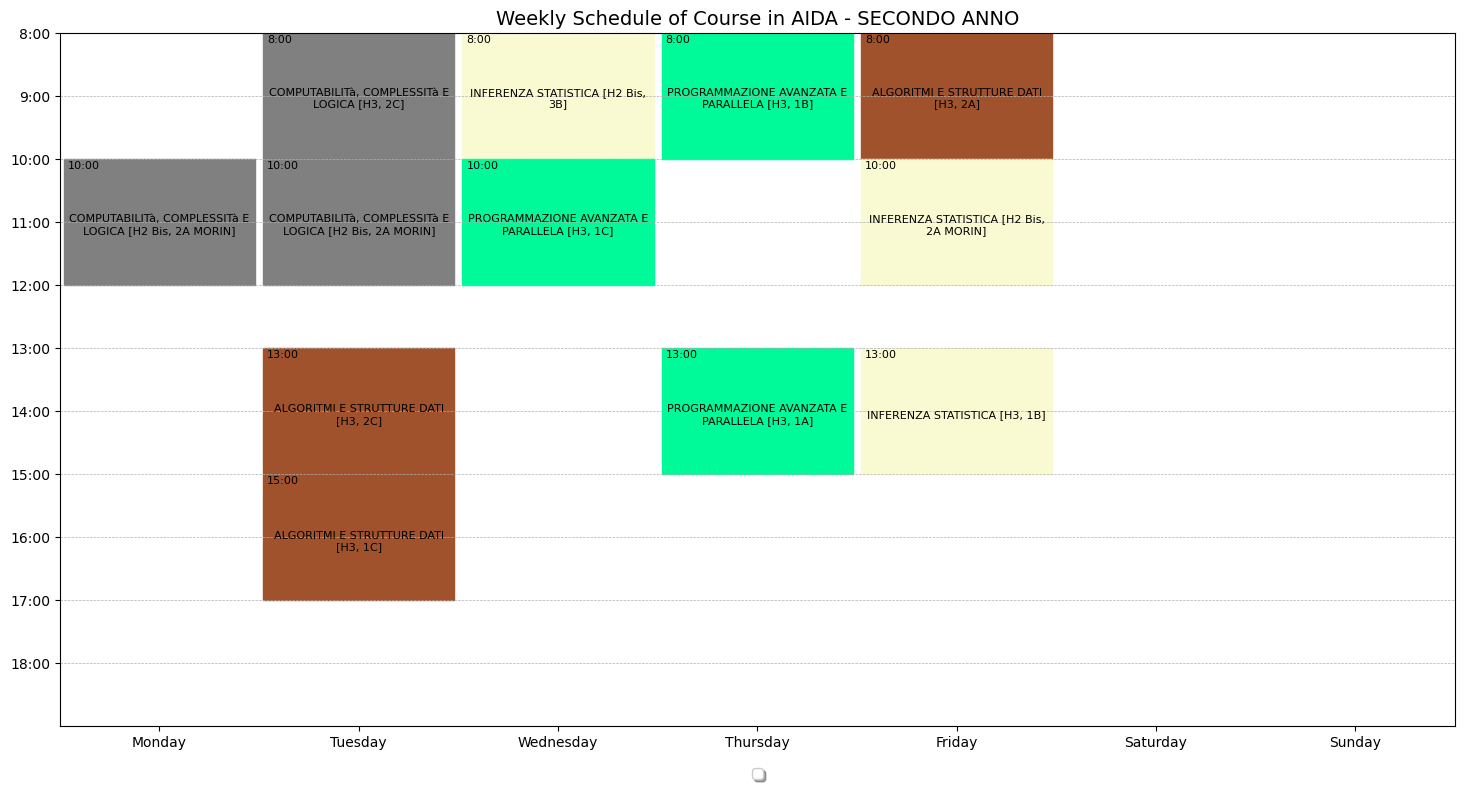

In [6]:
orario_aida.draw_calendar('AIDA', 'cds', 2)

c:\Users\ACER\Desktop\CourseTimetablingCSP\weekplot.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),


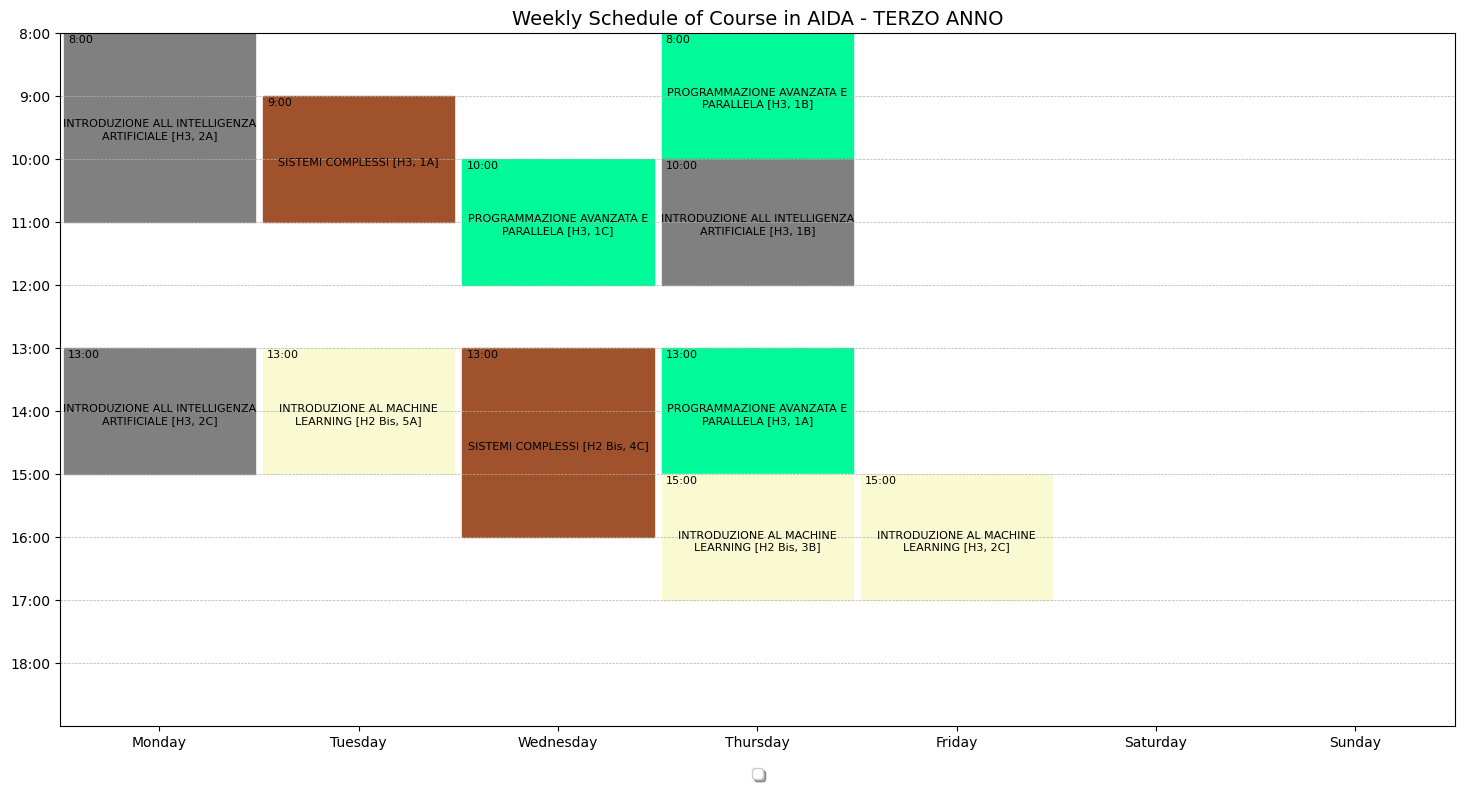

In [7]:
orario_aida.draw_calendar('AIDA', 'cds', 3)

In [22]:
orario_aida.end()

## Scenario 3: High School Timetable
Model creating a time table for the lessons of a class in high school, the last 3 years

*Modello che crea un orario settimanale per le lezioni del trienno di un liceo linguistico, solo per una classe (per semplicità assumiamo che tutti i professori siano assegnati ad una e sola classe)*

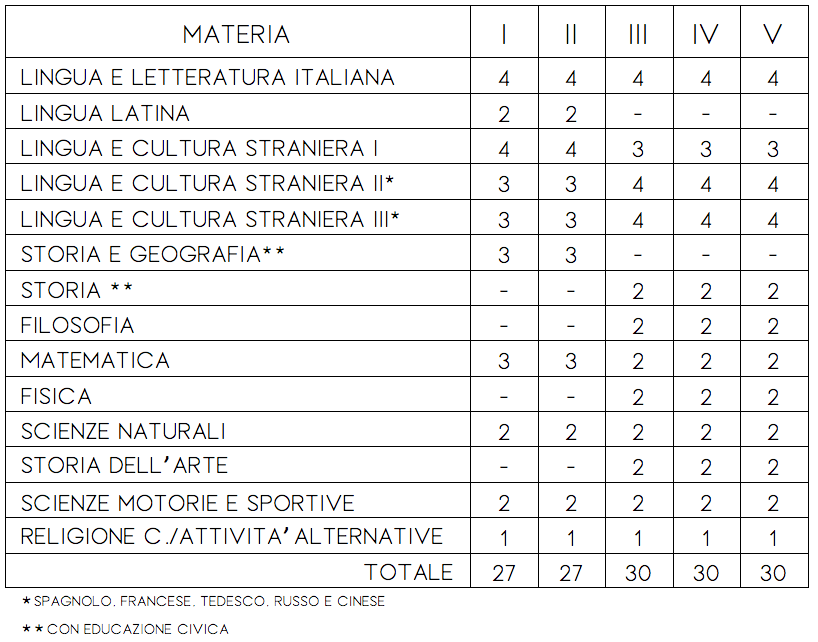
](https://www.istitutodantealighieri.it/wp-content/uploads/2023/01/quadro-LL-20-21.png)


Richieste specifiche:
- Nel quinto anno, le professoresse di Italiano e delle materie d'indirizzo (i.e. Inglese, Tedesco e Russo) hanno chiesto di ottenere uno slot da 3 ore, in un modo tale da consentire di svolgere delle esercitazioni della prima e seconda prova in vista della maturità.
- Inoltre, la professoressa di Storia e Filosofia ha chiesto di avere almeno uno slot da due ore, per delle motivazioni analoghe della prof. di Italiano.
- Tutte le classi hanno richiesto di avere le due ore di motoria attaccate, per evitare scomodità pratiche. 
- In vista agli esami di certificazioni delle lingue straniere Inglese e Tedesco, i professori hanno richiesto di ottenere almeno un slot da due ore per svolgere delle esercitazioni.

Vincoli specifici:
- Tutte le lezioni, tranne quelle di Motoria, saranno assegnate ad un'aula dedicata alla classe. Ad esempio, le lezioni di Italiano del 3° anno verranno assegnate solamente all'aula dedicata agli alunni del 3° anno.
- Esiste una sola aula per svolgere le lezioni di Motoria e quindi verrà condivisa tra le classi

In [2]:
liceo_timetable = TimetableScheduler('liceo', 5)

In [3]:
liceo_timetable.start()

In [25]:
liceo_timetable.add_constraints()

In [26]:
# Vincoli sulle aule

classi = liceo_timetable.indexes['CdS']
for classe in classi:
    corsi = liceo_timetable.database.get_courses(classe)
    for corso in corsi: 
        if corso in [1501, 2501, 3501]:
            continue # esclude motoria

        sessioni = liceo_timetable.database.get_sessions(corso)
        liceo_timetable.solver.add(
            And(
                [ Not(liceo_timetable.X[S, T, A]) for (S,T,A) in itertools.product(sessioni, liceo_timetable.T, liceo_timetable.indexes['Rooms']) if A != classe]
            
            )
        )
        

In [27]:
# Vincolo sulla palestra
sessioni_motoria = [
    i[0] for i in liceo_timetable.database.execute_query(
        """
            SELECT DISTINCT IDSession
            FROM Session
            WHERE IDCourse = 1501 OR IDCourse = 2501 OR IDCourse = 3501; 
        """
    )
]

liceo_timetable.solver.add(
    And(
        [Not(liceo_timetable.X[S, T, A]) for (S,T,A) in itertools.product(sessioni_motoria, liceo_timetable.T, liceo_timetable.indexes['Rooms']) if A in [1,2,3]]
    )
)

In [28]:
liceo_timetable.solver.set("timeout", 3000)

liceo_timetable.solve()
while not liceo_timetable.model:
    liceo_timetable.solve()
    print("Timed out, restarting...")

TIME TABLE SUCCESSFULLY CREATED
Saving the schedule in the SQL Database...
Schedule saved


In [29]:
from IPython.display import display, HTML 
df = liceo_timetable.print_schedule_df()
display(HTML(df.to_html().replace("\\n", "<br>")))

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
08:00 - 09:00,> FISICA [ANNO III]> FILOSOFIA [ANNO IV]> TERZA LINGUA STRANIERA (RUSSO) [ANNO V],> SCIENZE NATURALI [ANNO III]> LINGUA E LETTERATURA ITALIANA [ANNO IV]> TERZA LINGUA STRANIERA (RUSSO) [ANNO V],> PRIMA LINGUA STRANIERA (INGLESE) [ANNO III]> STORIA DELL'ARTE [ANNO IV]> LINGUA E LETTERATURA ITALIANA [ANNO V],> FILOSOFIA [ANNO III]> SCIENZE E MOTORIE SPORTIVE (ANNO II) [PALESTRA]> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO V],> SCIENZE NATURALI [ANNO III]> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO IV]> FILOSOFIA [ANNO V],> LINGUA E LETTERATURA ITALIANA [ANNO III]> SCIENZE NATURALI [ANNO IV]> FISICA [ANNO V]
09:00 - 10:00,> SCIENZE E MOTORIE SPORTIVE (ANNO I) [PALESTRA]> FISICA [ANNO IV]> TERZA LINGUA STRANIERA (RUSSO) [ANNO V],> STORIA [ANNO III]> LINGUA E LETTERATURA ITALIANA [ANNO IV]> FISICA [ANNO V],> PRIMA LINGUA STRANIERA (INGLESE) [ANNO III]> TERZA LINGUA STRANIERA (RUSSO) [ANNO IV]> LINGUA E LETTERATURA ITALIANA [ANNO V],> MATEMATICA [ANNO III]> SCIENZE E MOTORIE SPORTIVE (ANNO II) [PALESTRA]> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO V],> STORIA [ANNO III]> LINGUA E LETTERATURA ITALIANA [ANNO IV]> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO V],> LINGUA E LETTERATURA ITALIANA [ANNO III]> TERZA LINGUA STRANIERA (RUSSO) [ANNO IV]> SCIENZE E MOTORIE SPORTIVE (ANNO III) [PALESTRA]
10:00 - 11:00,> SCIENZE E MOTORIE SPORTIVE (ANNO I) [PALESTRA]> STORIA DELL'ARTE [ANNO IV]> TERZA LINGUA STRANIERA (RUSSO) [ANNO V],> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO III]> STORIA [ANNO IV]> STORIA DELL'ARTE [ANNO V],> MATEMATICA [ANNO III]> TERZA LINGUA STRANIERA (RUSSO) [ANNO IV]> LINGUA E LETTERATURA ITALIANA [ANNO V],> LINGUA E LETTERATURA ITALIANA [ANNO III]> MATEMATICA [ANNO IV]> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO V],> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO III]> LINGUA E LETTERATURA ITALIANA [ANNO IV]> PRIMA LINGUA STRANIERA (INGLESE) [ANNO V],> TERZA LINGUA STRANIERA (RUSSO) [ANNO III]> PRIMA LINGUA STRANIERA (INGLESE) [ANNO IV]> SCIENZE E MOTORIE SPORTIVE (ANNO III) [PALESTRA]
11:00 - 12:00,> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO III]> PRIMA LINGUA STRANIERA (INGLESE) [ANNO IV]> STORIA [ANNO V],> PRIMA LINGUA STRANIERA (INGLESE) [ANNO III]> TERZA LINGUA STRANIERA (RUSSO) [ANNO IV]> SCIENZE NATURALI [ANNO V],> STORIA DELL'ARTE [ANNO III]> FILOSOFIA [ANNO IV]> MATEMATICA [ANNO V],> LINGUA E LETTERATURA ITALIANA [ANNO III]> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO IV]> STORIA DELL'ARTE [ANNO V],> FILOSOFIA [ANNO III]> MATEMATICA [ANNO IV]> PRIMA LINGUA STRANIERA (INGLESE) [ANNO V],> TERZA LINGUA STRANIERA (RUSSO) [ANNO III]> FISICA [ANNO IV]> LINGUA E LETTERATURA ITALIANA [ANNO V]
12:00 - 13:00,> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO III]> PRIMA LINGUA STRANIERA (INGLESE) [ANNO IV]> STORIA [ANNO V],> FISICA [ANNO III]> RELIGIONE CATTOCIA O ATTIVITA' ALTERNATIVE [ANNO IV]> FILOSOFIA [ANNO V],> TERZA LINGUA STRANIERA (RUSSO) [ANNO III]> SCIENZE NATURALI [ANNO IV]> MATEMATICA [ANNO V],> STORIA DELL'ARTE [ANNO III]> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO IV]> RELIGIONE CATTOCIA O ATTIVITA' ALTERNATIVE [ANNO V],> TERZA LINGUA STRANIERA (RUSSO) [ANNO III]> STORIA [ANNO IV]> PRIMA LINGUA STRANIERA (INGLESE) [ANNO V],> RELIGIONE CATTOCIA O ATTIVITA' ALTERNATIVE [ANNO III]> SECONDA LINGUA STRANIERA (TEDESCO) [ANNO IV]> SCIENZE NATURALI [ANNO V]


c:\Users\ACER\Desktop\CourseTimetablingCSP\weekplot.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),


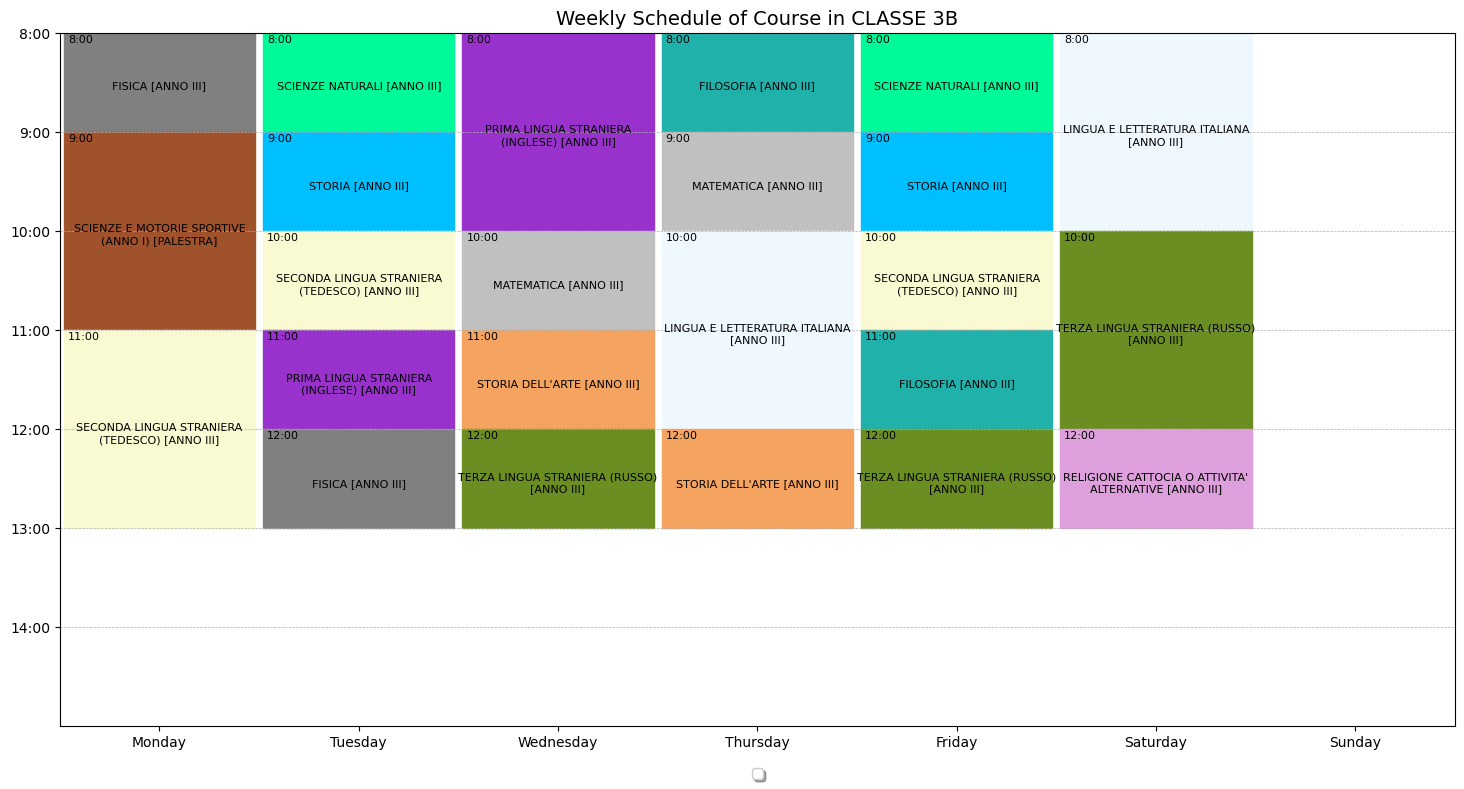

In [5]:
liceo_timetable.draw_calendar('Liceo F. Da Collo', 'cds', 1)

c:\Users\ACER\Desktop\CourseTimetablingCSP\weekplot.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),


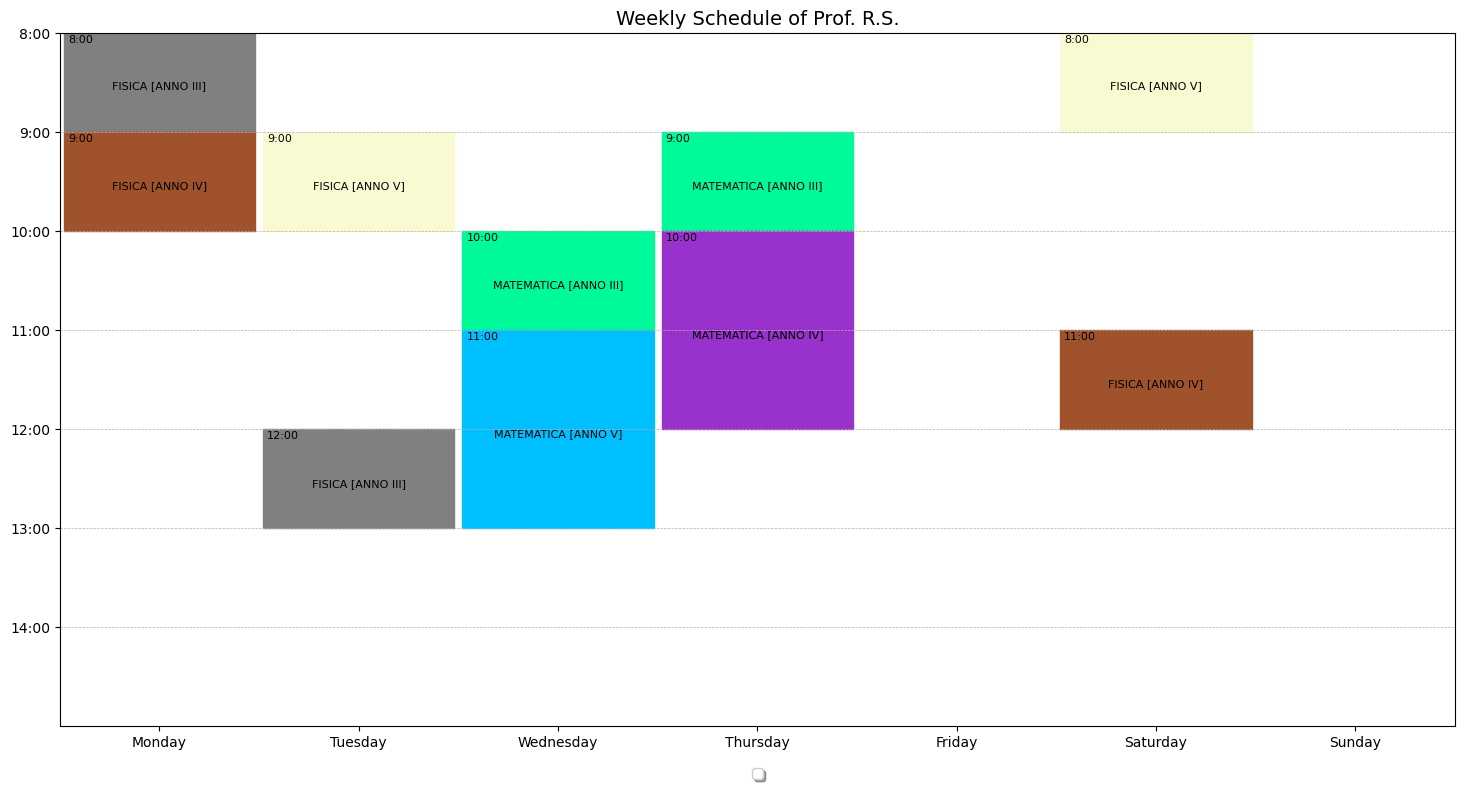

In [7]:
liceo_timetable.draw_calendar('Liceo F. Da Collo', 'prof', 6)

c:\Users\ACER\Desktop\CourseTimetablingCSP\weekplot.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),


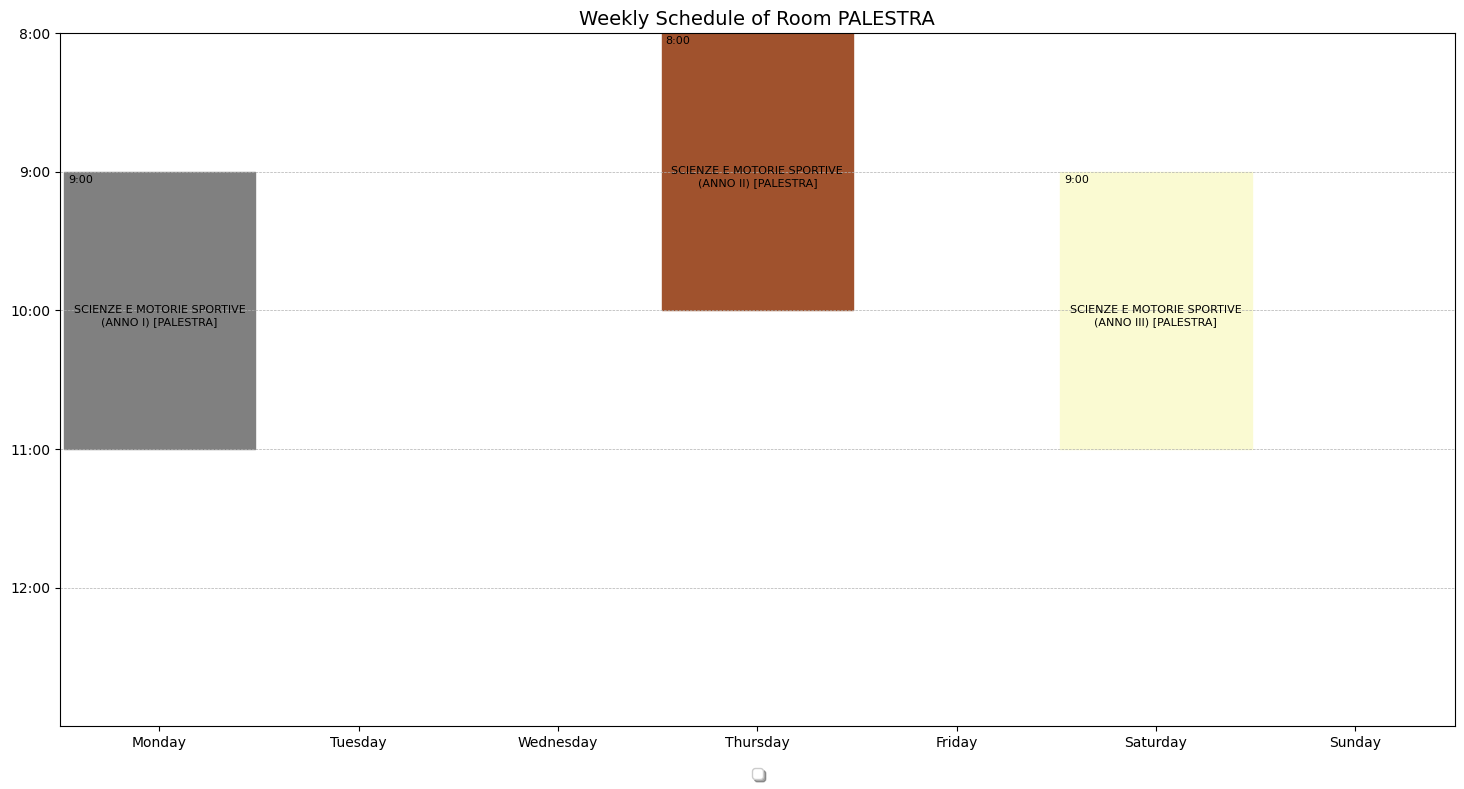

In [6]:
liceo_timetable.draw_calendar('Liceo F. Da Collo', 'room', 4)

In [30]:
liceo_timetable.end()

Fine della demo